In [1]:
import os

In [2]:
os.getcwd() 

'C:\\Users\\91938\\Desktop\\knife detection'

In [3]:
path_dataset=os.path.join('C:\\Users\\91938\\Desktop\\knife detection','dataset') #Path for datasets


In [4]:
os.listdir(path_dataset)

['without_knife', 'with_knife']

In [5]:
Target_variable = os.listdir(path_dataset)

In [42]:
data = [] 
labels = [] 

In [43]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [44]:
for target in Target_variable:
    path = os.path.join(path_dataset,target)   #We are inside the folder with_mask and without_mask
    for img in os.listdir(path):      # We will get a list of images in the current path
        img_path = os.path.join(path,img)
        image = load_img(img_path,target_size = (224,224))  # Loads image with a target size
        image = img_to_array(image)   # Converting image to an array.
        image = preprocess_input(image)   # When we use mobilenets we have to preprocess_input
        
        data.append(image)
        labels.append(target)
    

In [45]:
from sklearn.preprocessing import LabelBinarizer

In [46]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [47]:
from tensorflow.keras.utils import to_categorical

In [48]:
labels = to_categorical(labels)

In [49]:
import numpy as np

In [50]:
data = np.array(data,dtype="float32")

In [51]:
labels = np.array(labels)

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
X_train,X_test,y_train,y_test = train_test_split(data,labels,test_size=.20,stratify = labels,random_state=42)

In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [55]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [56]:
Learning_rate = 1e-3 

In [57]:
Epochs = 15

In [58]:
BS = 25

In [59]:
from tensorflow.keras.applications import MobileNetV2

In [60]:
from tensorflow.keras.layers import Input

In [61]:
base_model = MobileNetV2(weights = 'imagenet',include_top = False,input_tensor = Input(shape=(224,224,3)))

In [62]:
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [63]:
headModel = base_model.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [64]:
from tensorflow.keras.models import Model

In [65]:
model = Model(inputs=base_model.input, outputs=headModel)

In [66]:
for layer in base_model.layers:
	layer.trainable = False

In [67]:
from tensorflow.keras.optimizers import Adam

In [68]:
optim = Adam(lr=Learning_rate, decay=Learning_rate/ Epochs)
model.compile(loss="binary_crossentropy", optimizer=optim,metrics=["accuracy"])

C:\Users\91938\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [69]:
H = model.fit(
    aug.flow(X_train, y_train, batch_size=BS),
    steps_per_epoch=len(X_train) // BS,
    validation_data=(X_test,y_test),
    validation_steps=len(X_test) // BS,
    epochs=Epochs)

Epoch 1/15
21/21 [==============================] - 15s 546ms/step - loss: 0.2893 - accuracy: 0.8757 - val_loss: 0.0813 - val_accuracy: 0.9852
Epoch 2/15
21/21 [==============================] - 10s 491ms/step - loss: 0.0952 - accuracy: 0.9631 - val_loss: 0.0436 - val_accuracy: 0.9852
Epoch 3/15
21/21 [==============================] - 10s 493ms/step - loss: 0.0710 - accuracy: 0.9748 - val_loss: 0.0418 - val_accuracy: 0.9926
Epoch 4/15
21/21 [==============================] - 11s 535ms/step - loss: 0.0523 - accuracy: 0.9864 - val_loss: 0.0275 - val_accuracy: 0.9926
Epoch 5/15
21/21 [==============================] - 11s 498ms/step - loss: 0.0318 - accuracy: 0.9864 - val_loss: 0.0169 - val_accuracy: 0.9926
Epoch 6/15
21/21 [==============================] - 11s 499ms/step - loss: 0.0236 - accuracy: 0.9903 - val_loss: 0.0140 - val_accuracy: 0.9926
Epoch 7/15
21/21 [==============================] - 11s 497ms/step - loss: 0.0194 - accuracy: 0.9981 - val_loss: 0.0131 - val_accuracy: 0.9926

In [70]:
predictions = model.predict(X_test, batch_size=BS)

In [71]:
predictions = np.argmax(predictions, axis=1)

In [72]:
from sklearn.metrics import classification_report

In [73]:
X_test[1].shape

(224, 224, 3)

In [74]:
print(classification_report(y_test.argmax(axis=1), predictions,target_names=lb.classes_))

               precision    recall  f1-score   support

   with_knife       1.00      1.00      1.00       115
without_knife       1.00      1.00      1.00        20

     accuracy                           1.00       135
    macro avg       1.00      1.00      1.00       135
 weighted avg       1.00      1.00      1.00       135



In [75]:
model.save("knife_detector.model4", save_format="h5")

In [76]:
import matplotlib.pyplot as plt

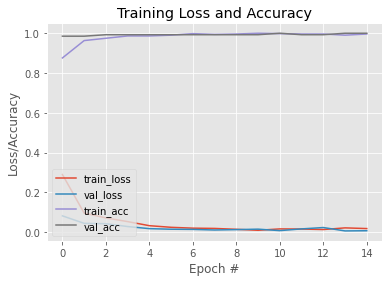

In [77]:
N = Epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")